In [213]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup random seed
RANDOM_SEED = 42

In [214]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

n_samples = 1000
X, y = make_moons(n_samples=n_samples,
                  noise = 0.03,
                  random_state=RANDOM_SEED)

In [215]:
print(f"First 5 rows of X:\n {X[:5]}")
print(f"First 5 rows of y:\n {y[:5]}")

First 5 rows of X:
 [[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]
First 5 rows of y:
 [1 1 1 1 0]


In [216]:
# Turn data into a DataFrame
import pandas as pd

df = pd.DataFrame({"X1": X[:,0],
                  "X2": X[:,1],
                  "label": y})

df.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


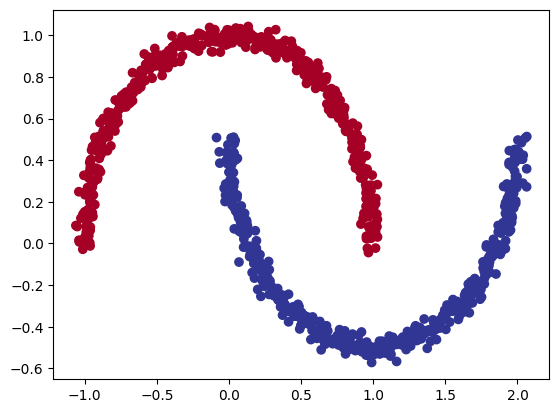

In [217]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(df["X1"],
            df["X2"],
            c= df["label"],
            cmap = plt.cm.RdYlBu)


In [218]:
X.shape, y.shape

((1000, 2), (1000,))

In [219]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.2,
                                                    random_state=RANDOM_SEED)


In [220]:
# View the first sample of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Sample input features: {X_sample}")
print(f"Sample target label: {y_sample}")

# Check the shape of input features and target labels
print(f"Shape of input features (X): {X_sample.shape}")
print(f"Shape of target labels (y): {y_sample.shape}")

Sample input features: tensor([-0.0093,  0.3910])
Sample target label: 1.0
Shape of input features (X): torch.Size([2])
Shape of target labels (y): torch.Size([])


In [221]:
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [222]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    ## Your code here ##
    def __init__(self):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
    def forward(self, x):
        ## Your code here ##
        return self.layer(x)

# Instantiate the model
## Your code here ##
model_0 = MoonModelV0()
model_0

MoonModelV0(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [223]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [ ]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [ ]:

torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  y_logits = model_0(X_train).squeeze()

  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)


  # Turn prediction probabilities into prediction labels
  y_pred_labels = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred_labels, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  #
  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Turn the test logits into prediction labels


    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72029 | Acc: 0.48% | Test Loss: 0.71025 | Test Acc: 0.50%
Epoch: 100 | Loss: 0.33116 | Acc: 0.83% | Test Loss: 0.33510 | Test Acc: 0.83%
Epoch: 200 | Loss: 0.23904 | Acc: 0.88% | Test Loss: 0.23819 | Test Acc: 0.89%
Epoch: 300 | Loss: 0.19852 | Acc: 0.89% | Test Loss: 0.19675 | Test Acc: 0.92%
Epoch: 400 | Loss: 0.16143 | Acc: 0.92% | Test Loss: 0.16030 | Test Acc: 0.94%
Epoch: 500 | Loss: 0.11783 | Acc: 0.96% | Test Loss: 0.11803 | Test Acc: 0.96%
Epoch: 600 | Loss: 0.07797 | Acc: 0.99% | Test Loss: 0.07961 | Test Acc: 0.98%
Epoch: 700 | Loss: 0.05001 | Acc: 1.00% | Test Loss: 0.05267 | Test Acc: 0.99%
Epoch: 800 | Loss: 0.03309 | Acc: 1.00% | Test Loss: 0.03610 | Test Acc: 1.00%
Epoch: 900 | Loss: 0.02315 | Acc: 1.00% | Test Loss: 0.02627 | Test Acc: 1.00%


In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

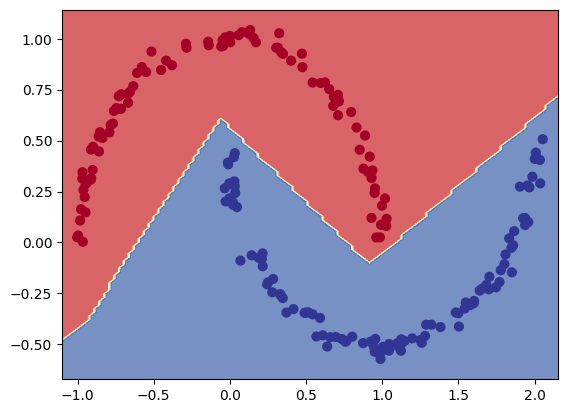

In [227]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_0, X_train, y_train)

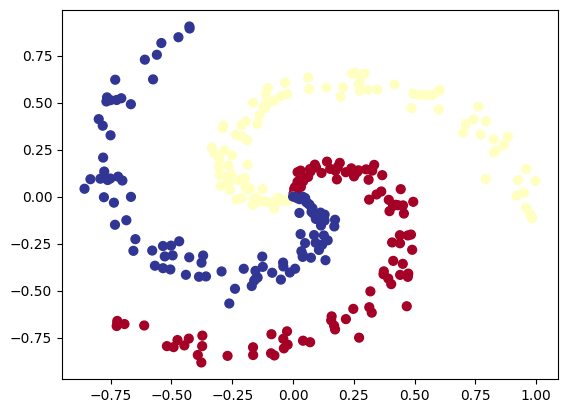

In [240]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [241]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    train_size=0.2,
                                                    random_state=RANDOM_SEED)


In [ ]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [291]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class MultiClassModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=3)
            )

    def forward(self, x):
      return self.layer(x)


# Instantiate model and send it to device
model_1 = MultiClassModel().to(device)
model_1

MultiClassModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:

X_trian, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


Logits:
Pred probs:
Pred labels:


In [293]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.1)

In [294]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ## Testing

  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.13489, Acc: 0.25% | Test Loss: 1.13308, Test Acc: 0.32%
Epoch: 100 | Loss: 0.04032, Acc: 1.00% | Test Loss: 0.45799, Test Acc: 0.95%
Epoch: 200 | Loss: 0.00275, Acc: 1.00% | Test Loss: 0.42789, Test Acc: 0.97%
Epoch: 300 | Loss: 0.00089, Acc: 1.00% | Test Loss: 0.40580, Test Acc: 0.97%
Epoch: 400 | Loss: 0.00044, Acc: 1.00% | Test Loss: 0.39712, Test Acc: 0.98%
Epoch: 500 | Loss: 0.00027, Acc: 1.00% | Test Loss: 0.38480, Test Acc: 0.98%
Epoch: 600 | Loss: 0.00018, Acc: 1.00% | Test Loss: 0.38265, Test Acc: 0.98%
Epoch: 700 | Loss: 0.00013, Acc: 1.00% | Test Loss: 0.39446, Test Acc: 0.97%
Epoch: 800 | Loss: 0.00010, Acc: 1.00% | Test Loss: 0.39499, Test Acc: 0.97%
Epoch: 900 | Loss: 0.00008, Acc: 1.00% | Test Loss: 0.41267, Test Acc: 0.97%


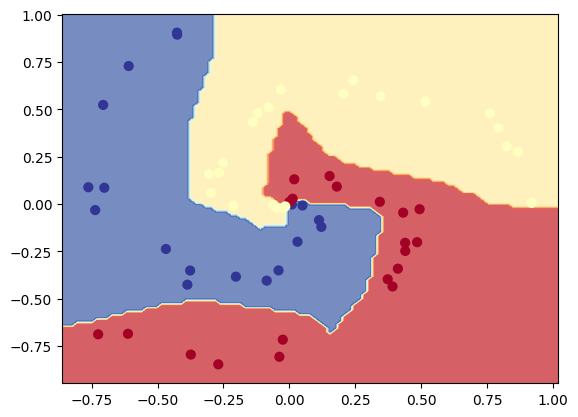

In [295]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_1, X_train, y_train)